In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(),
])

Batch_size = 4

train_data = torchvision.datasets.ImageFolder(root='Concrete_data/train', transform = transform)
test_data = torchvision.datasets.ImageFolder(root='Concrete_data/test', transform = transform)
train_loader = DataLoader(train_data, batch_size=Batch_size,shuffle=True)
test_loader = DataLoader(test_data, batch_size=Batch_size,shuffle=True)


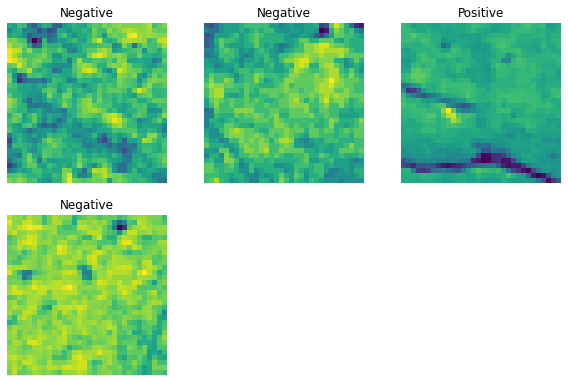

In [3]:
class_names = train_loader.dataset.classes  

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 10))
for i in range(len(images)):   
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # (C,H,W) -> (H,W,C)
    plt.title(class_names[labels[i].item()])  
    plt.axis('off')
plt.show()


In [4]:
class ImageClassificationNet(nn.Module):
    def __init__(self):
        super(ImageClassificationNet, self).__init__()
        self.c1 = nn.Conv2d(1,6,3) 
        self.p = nn.MaxPool2d(2,2)
        self.c2 = nn.Conv2d(6,16,3)        
        self.fc1 = nn.Linear(16*6*6,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        
    def forward(self, x): # input 1,32,32
        
        x = self.c1(x)         # out 6,30,30
        x = nn.functional.relu(x)
        x = self.p(x)             # out 6,15,15
        x = self.c2(x)         # out 16,13,13
        x = nn.functional.relu(x)
        x = self.p(x)             # out 16,6,6
        x = torch.flatten(x,1)    # out 16*6*6
        x = self.fc1(x)           # out 128
        x = self.relu(x)
        x = self.fc2(x)           # out 64
        x = self.relu(x)
        x = self.fc3(x)           # out 2
        
        return x

In [5]:
model = ImageClassificationNet()

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/3], Loss: 0.0805
Epoch [2/3], Loss: 0.0360
Epoch [3/3], Loss: 0.0293


In [13]:
pred = []
true = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        pred.extend(predicted)
        true.extend(labels)

In [15]:
acc = accuracy_score(pred,true)
print(f"Test Accuracy: {100 * acc:.2f}%")

Test Accuracy: 99.20%
